#Home assignment 12
Aleksandr Zybin \\
Yaroslav Stepanov

## Problem 1
Excercise 12.3
Consider a modiﬁcation to (12.43) where you do not penalize the constant. Formulate the problem, and characterize its solution.

The formulation of the problem is ($\beta_0$ is not penalised): \\
> $H(\beta,\beta_{0})=\sum_{i=1}^{N}V(y_{i}-f(x_{i}))+\frac{\lambda}{2}\sum_{m=1}^{M}\beta^{2}_{m}\rightarrow min$, where $f(x)=\sum_{m=1}^{M}\beta_{m}h_{m}(x)+β_{0}$


In order to simplify the derivation let us assume that $V(r)=r^2$. Thus,


> $H(\beta,\beta_{0})=\sum_{i=1}^{N}(y_{i}-f(x_{i}))^{2}+\frac{\lambda}{2}\sum_{m=1}^{M}\beta^{2}_{m}\rightarrow min$
>
>$H(\beta,\beta_{0})=\Vert y-\beta H-\beta_{0}\Vert^{2}+\frac{\lambda}{2}\Vert\beta\Vert^{2}\rightarrow min$
>
We can simplify the equation as follows:
>$H(\beta,\beta_{0})=y^{T}y-y^{T}(\beta H-\beta_{0})-y(\beta H-\beta_{0})^{T}-(\beta H-\beta_{0})^{T}(\beta H-\beta_{0})+\frac{\lambda}{2}\beta^{T}\beta$
>
Then we take the derivative with respect to $\beta$:
>$\nabla H(\hat{\beta})=0$
>
>$H^{T}y-H^{T}\hat{\beta}_{0}=H^{T}H\hat{\beta}+\frac{\lambda}{2}\hat{\beta}$
> 
>$\hat{\beta}=[H^{T}H+\frac{\lambda}{2}I]^{-1}(H^{T}y-H^{T}\hat{\beta}_{0})$



## Problem 2

In [ ]:
#Download libraries
install.packages("data.table", quite=TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#Import library to read the dataframe
library(data.table)

#Read dataframe (Two's from digits database)
df = fread("https://raw.githubusercontent.com/omelnikov/data/main/phoneme/phoneme.data")

#Head of the dataframe
head(df)

row.names,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,⋯,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,⋯,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,⋯,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,⋯,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,⋯,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,⋯,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1
6,11.66525,12.43949,14.74297,18.83307,18.55868,14.86749,11.23968,19.37642,20.70066,⋯,6.80571,6.47949,7.94855,7.39302,7.49989,8.64981,7.38444,7.41388,iy,train.dr1.mcpm0.sa1


### **a)**

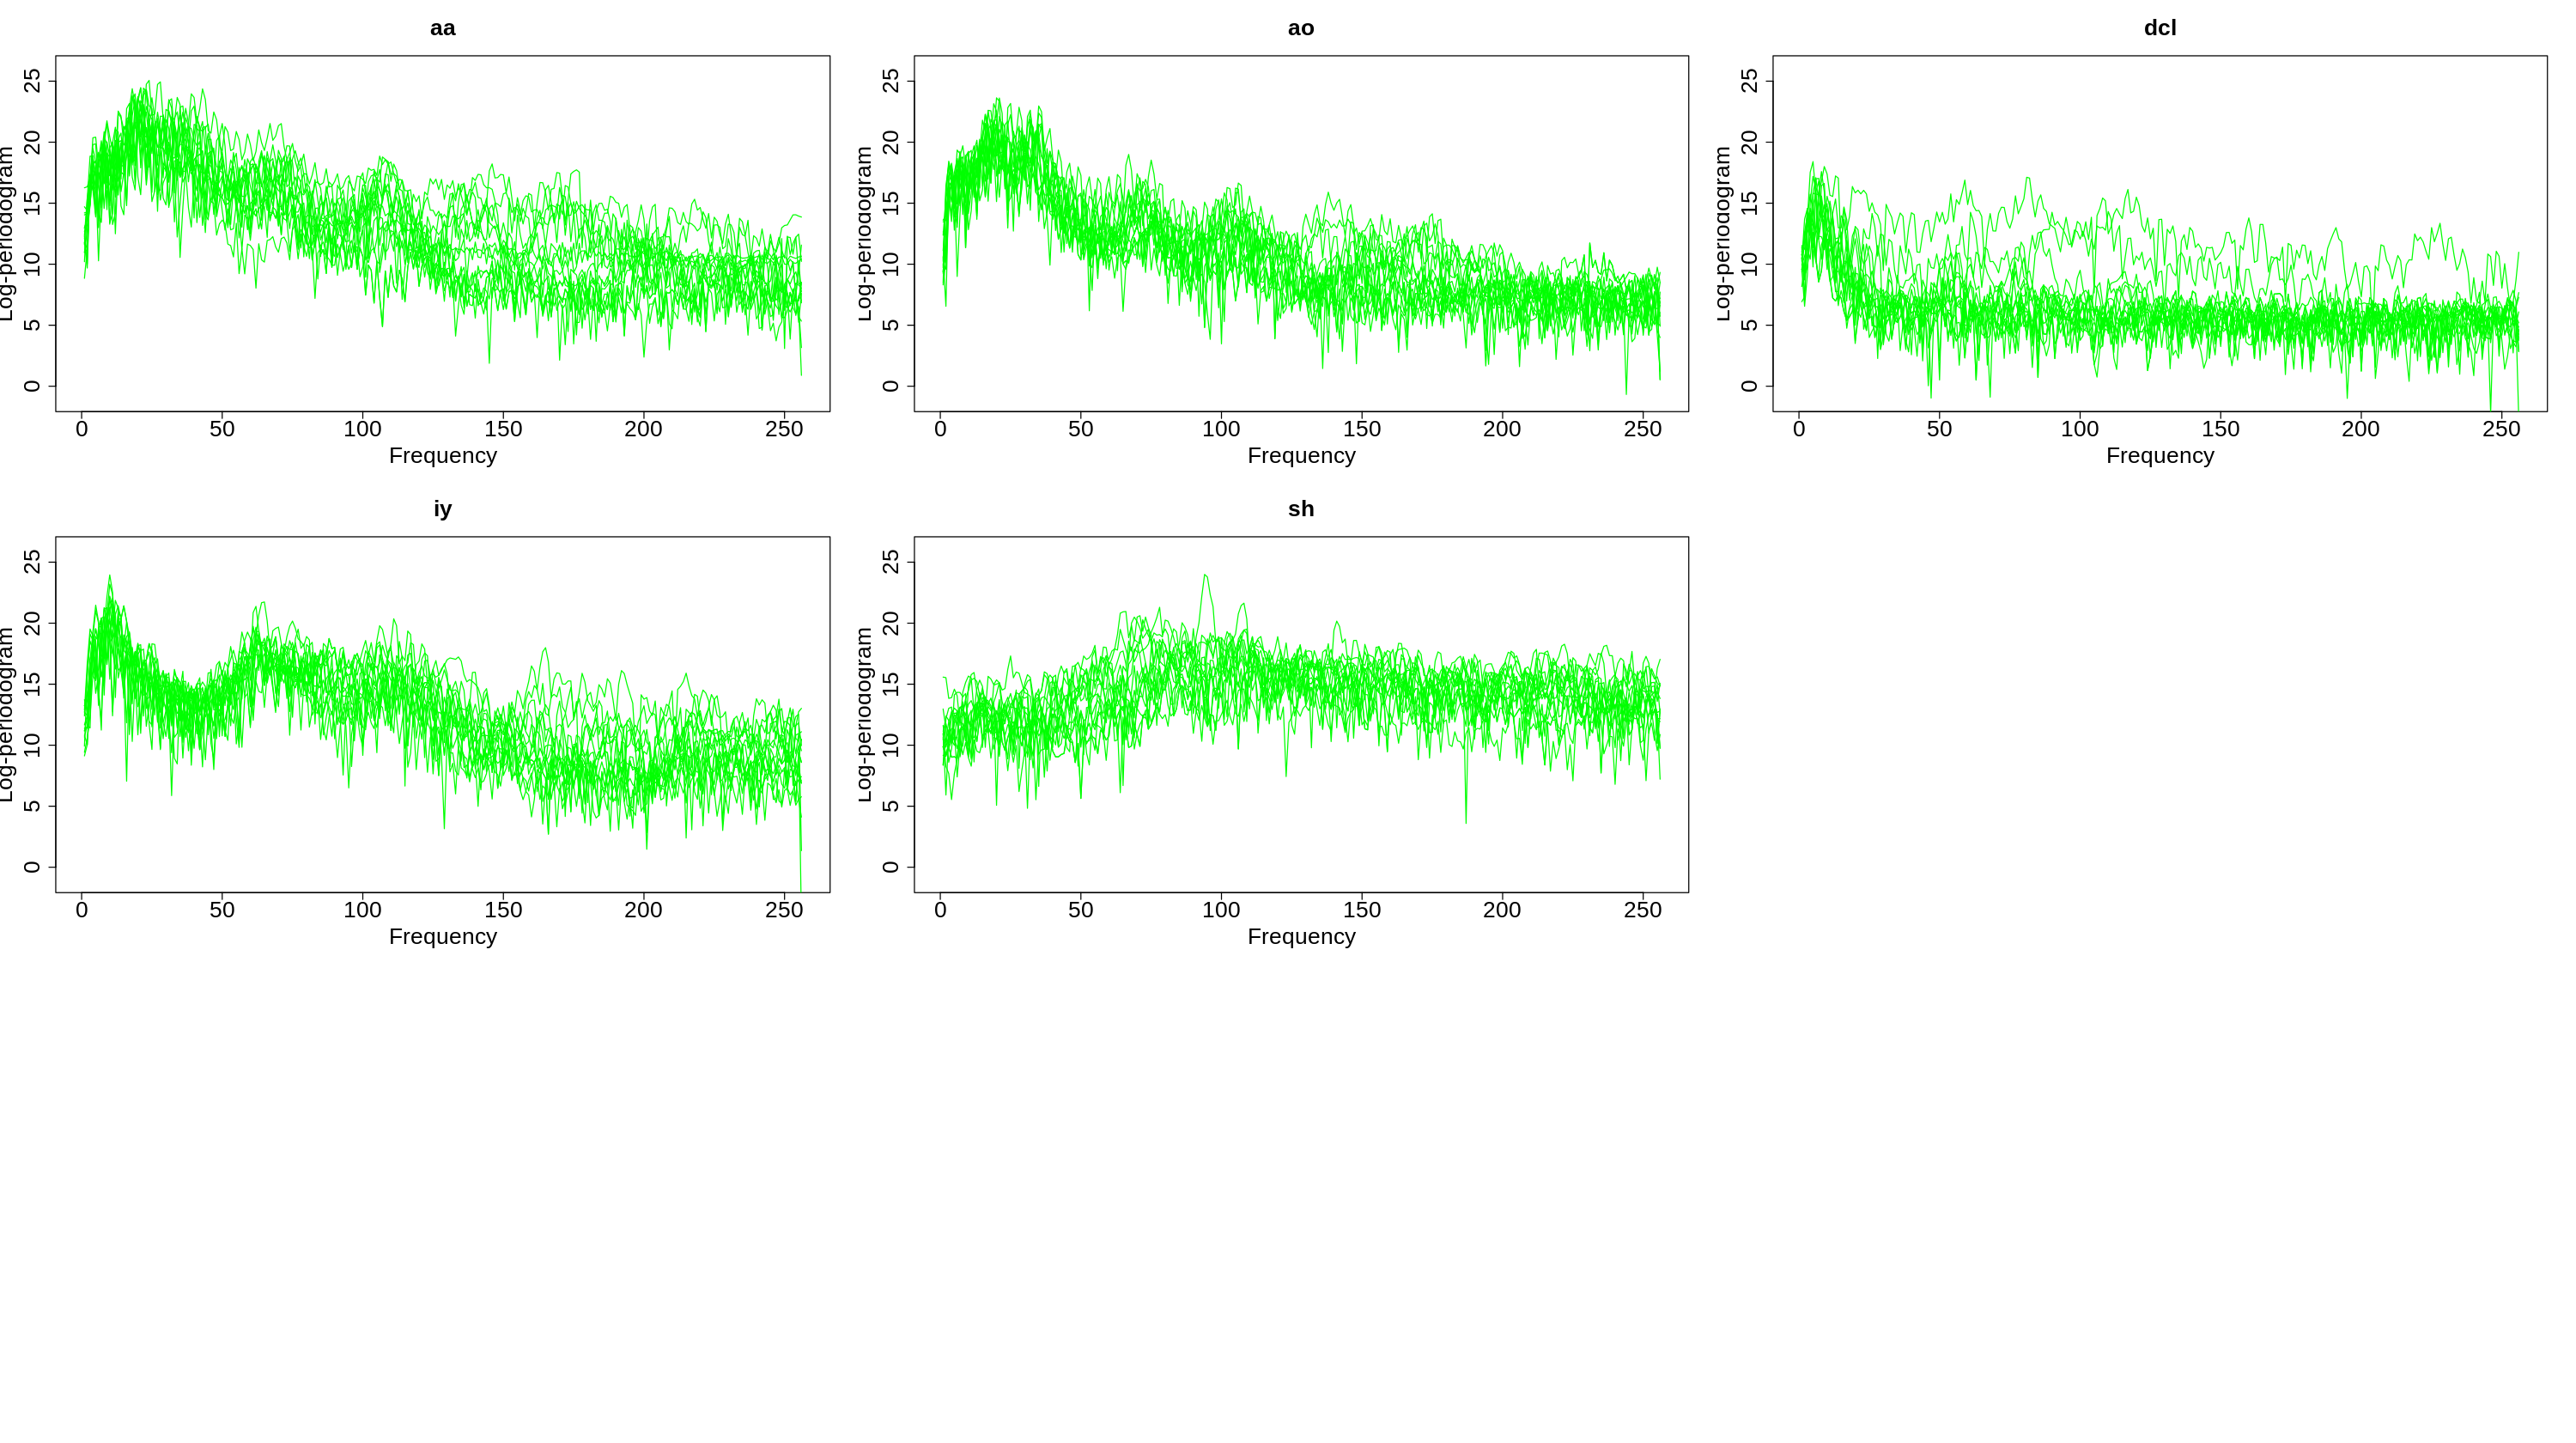

In [ ]:
#Create a list of phonemes
phonemes = c("aa", "ao", "dcl", "iy",  "sh")

#Set plot size
options(repr.plot.width=25, repr.plot.height=14)

#Plot of all the phoneme curves against frequency
par(mfrow=c(3,3), cex.lab=2, cex.axis=2, cex.main=2)
x = seq(1,256)
for (phoneme in phonemes) {
  #Plot the first line
  df_phoneme = df[df$g == phoneme,][,2:257]
  plot(x, df_phoneme[1,], type="l", main=phoneme, xlab="Frequency", 
        ylab="Log-periodogram", col="green", ylim=c(-1,26))
  #Plot line for 15 row (as in the book)
  for (row in seq(1:15)) {
    lines(x, df_phoneme[row,], col="green")
  }
}

### **b)** 
To avoid costly high-dimensional fitting procedures, we would use splines to reduce dimensions of the dataset. Namely, we calculate a natural spline basis (a cubic spline) for each row of the data set. Then we multiply it by the original row to get the the corresponding coefficients. As a result, one of the dimensions of the data is reduced (columns).

### **c)** 
We are going to use [Mike's answer](https://piazza.com/class/kjf7dip4hq13il?cid=268) (@268) for splitting the data into test and train parts without splitting the speakers. And a function from Stackoverflow to predict clusters for new data.

It is important to make sure that the speakers are not split across train and test sets because such leakage of data would result in a biased model.

In [ ]:
library(splines)

transform_data <- function(data, nknots){
  #Multiply each row by its basis to get the coefficients (reduced form)
  rows = seq(1, nrow(data))

  #Create a new dataframe
  data_reduced <- data.frame(matrix(NA, ncol = nknots+2, nrow = nrow(data)))
  for (row in rows) {
    #Calculate basis for each row in the dataset
    B <- ns(as.matrix(data[row,2:257]), intercept = TRUE, df=nknots+2)

    #Calculate coefficients of each row (observation)
    data_reduced[row,] <- as.matrix(data[1,2:257]) %*% B
  }
  #Add name of the speaker and the correponding phoneme columns
  data_reduced <- cbind(data_reduced, data[,258:259])

  return (data_reduced)
}

data_reduced <- transform_data(df, 10)

head(data_reduced)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,g,speaker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,129.2305,365.9623,308.2441,239.4899,333.0874,342.0729,291.9548,288.5800,581.4642,204.07375,155.2058,-2.541287,sh,train.dr1.mcpm0.sa1
2,172.6115,527.7783,346.4829,286.7850,290.6593,251.6383,261.2935,355.4310,439.2704,142.04462,149.2665,-15.640778,iy,train.dr1.mcpm0.sa1
3,156.8911,408.2805,332.9530,309.3494,313.9358,344.1887,275.1794,306.6943,502.6619,63.38498,157.9717,-27.837882,dcl,train.dr1.mcpm0.sa1
4,171.3603,394.5100,279.9664,342.2564,340.1061,326.6929,305.3317,333.5613,461.4540,46.45115,159.7839,-27.259896,dcl,train.dr1.mcpm0.sa1
5,160.3183,484.3941,345.9156,325.5366,315.9605,386.5414,213.6275,232.3325,312.0146,169.89179,204.2798,-16.188647,aa,train.dr1.mcpm0.sa1
6,154.5015,475.1066,374.9644,342.2242,203.4680,232.3630,325.3435,328.7341,418.1597,151.05429,178.7072,-17.172032,iy,train.dr1.mcpm0.sa1


In [ ]:
#Predict the data using the function https://stackoverflow.com/questions/49016343/what-package-to-use-in-r-for-kmeans-prediction
predict.kmeans <- function(object, newdata){
    centers <- object$centers
    n_centers <- nrow(centers)
    dist_mat <- as.matrix(dist(rbind(centers, newdata)))
    dist_mat <- dist_mat[-seq(n_centers), seq(n_centers)]
    max.col(-dist_mat)
}

kmeans_clusters <- function(train, test, n_clusters, nknots){
  #Set random seed to reproduce results
  set.seed(1)

  #Fit the kmeans model on training data
  km <- kmeans(as.matrix(train[, 1:nknots+2]), n_clusters)

  #Predict the data
  y_pred <- predict.kmeans(km, as.matrix(test[, 1:nknots+2]))
  return (y_pred)
}

In [ ]:
#Combine all the function into one
splines_kmeans <- function(data, nknots, n_clusters) {
  data_reduced <- transform_data(data, nknots)

  #Code from Mike's answer to split the data into test and training parts
  data_reduced$speaker = sapply(strsplit(data_reduced$speaker, split='.', fixed=TRUE), function(x) (x[3]))

  unique_speakers = unique(data_reduced$speaker)
  speakers_cnt = length(unique_speakers)
  train_speakers = unique_speakers[seq(1, speakers_cnt, 2)]

  train = data_reduced[data_reduced$speaker %in% train_speakers,]
  test = data_reduced[!(data_reduced$speaker %in% train_speakers),]

  #Fit and predict
  y_pred <- kmeans_clusters(train, test, n_clusters, nknots)
  temp <- cbind(test, y_pred)

  #Return crosstab (percentages per cluster)
  return (prop.table(table(temp$y_pred, temp$g), 1) * 100)
}

In [ ]:
#Compute the results
K <- c(1, 3, 5, 7)
J <- c(5, 10, 15)

#Compute results for each pair of k and j
set.seed(1)
for (k in K){
  for (j in J){
    print((paste("Results of clustering with", k, "cluster and", j, "knots:")))
    res <- splines_kmeans(df, j, k)
    print(res)
  }
}

[1] "Results of clustering with 1 cluster and 5 knots:"
   
          aa       ao      dcl       iy       sh
  1 14.99777 23.05296 16.64441 25.90120 19.40365
[1] "Results of clustering with 1 cluster and 10 knots:"
   
          aa       ao      dcl       iy       sh
  1 14.99777 23.05296 16.64441 25.90120 19.40365
[1] "Results of clustering with 1 cluster and 15 knots:"
   
          aa       ao      dcl       iy       sh
  1 14.99777 23.05296 16.64441 25.90120 19.40365
[1] "Results of clustering with 3 cluster and 5 knots:"
   
           aa        ao       dcl        iy        sh
  1 27.754533 38.493724 10.878661  9.902371 12.970711
  2 13.333333 17.530864  2.469136 51.234568 15.432099
  3  4.166667 13.888889 38.333333 13.333333 30.277778
[1] "Results of clustering with 3 cluster and 10 knots:"
   
           aa        ao       dcl        iy        sh
  1 28.953488 46.046512 14.534884  4.186047  6.279070
  2 13.211382 19.512195  9.349593 47.560976 10.365854
  3  2.569832  2.905028 2

From the crosstabs above we can see that the observations are better separated by the models with 5 knots. Moreover, it seems that the model with 5 clusters and 5 knots suits this data the best.